In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from functools import reduce
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import pickle

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 OFF


2024-02-12 22:49:31.461487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 22:49:31.565819: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 22:49:31.592571: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 22:49:32.102508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

#### 데이터 준비

In [9]:
df = pd.read_csv('/home/user/exercise_j/GPT Project/CoinMarketCapAPI/CMC_final.csv')
df2 = pd.read_csv('/home/user/exercise_j/TwitterXAPI/10000Tweets_Crypto_data.csv')

In [10]:
# 'created_at' 컬럼을 'date'로 이름 변경
df2 = df2.rename(columns={'created_at': 'date'})
df2 = df2.rename(columns={'text': 'text_content'})

# df2를 df에 이어붙이기 (행 방향으로 병합)
combined_df = pd.concat([df, df2], axis=0)

# 결과 확인
print(combined_df)

                                            text_content        date ticker  \
0      🚨  @BitMEX introduces Margin+, an exclusive pr...  2024-01-25    BTC   
1      📊 The $ETH  / $BTC  ratio has retraced nearly ...  2024-01-25    ETH   
2      $BTC be matter of when, Elon will start using ...  2024-01-25    BTC   
3      Successful Analyst Announced the Level to Watc...  2024-01-25    BTC   
4      They will suddenly boost Bitcoin $BTC   Short ...  2024-01-25    BTC   
...                                                  ...         ...    ...   
10113  What good long term projects are making you th...  2022-05-03    BTC   
10114  Unpopular opinion: Kylo Ren should’ve been the...  2022-05-01    BTC   
10115  Project under 100 million marketcap  that you ...  2022-05-01    BTC   
10116  @simsalacrypto Really? I think people will fom...  2022-04-29    ETH   
10117  Will Ethereum 2.0 upgrade kick off the next bu...  2022-04-29    ETH   

       sentiment_score  
0                 0.80  
1

In [11]:
df = combined_df

In [12]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,text_content,date,ticker,sentiment_score
0,Absolutely Stunning Vector Inspiration http://...,2010-10-30,BTC,0.00
1,@yogavenger Thanks for the RTs,2010-11-01,BTC,0.75
2,Massive Social Media Icon Collection http://bi...,2010-11-03,BTC,0.00
3,Is the User Mastermind Behind Web Design? http...,2010-11-04,BTC,0.00
4,Everyone give a big happy birthday to @robertb...,2010-11-05,BTC,0.00


#### (가장 데이터가 많이 존재하는)최근 6개월의 데이터로 input_data 설정
##### 2023.06.01 ~ 2023.12.31

In [13]:
start_date = '2023-06-01'
end_date = '2023-12-31'
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
filtered_df

,text_content,date,ticker,sentiment_score
0,$DOT and $KSM lets go 🙌🙌🙌🐂🐂🐂,2023-06-01,DOT,1.0
1,$DOT Analyst: Bulls pushed Polkadot above the...,2023-06-01,DOT,-0.7
2,$DOT half way to 1k DOT. Please keep dropping.,2023-06-01,DOT,-0.1
3,😎 Are you a $DOT fan? \n\n📲 We just introduced...,2023-06-01,DOT,0.8
4,RT @vdWijden: Are you interested in core devel...,2023-06-01,ETH,0.0
...,...,...,...,...
49796,$NIOCTIB rev of btc .. pump lead pump .. once ...,2023-12-31,BTC,0.8
49797,📢Lambe News : \n\nThe SEC could notify issuers...,2023-12-31,BTC,0.8
49798,"Last day of 2023, our thoughts on blockchain g...",2023-12-31,BTC,0.8
49799,nex bitcoin,2023-12-31,BTC,0.0


1. 티커별로 분류
2. 각 티커별로 input_data 생성
 - input_data의 구성은 created_at sentiment_score

In [14]:
# 1. 티커별로 데이터프레임을 분류
tickers = filtered_df['ticker'].unique()
ticker_dfs = {ticker: filtered_df[filtered_df['ticker'] == ticker] for ticker in tickers}

# 2. 각 티커에 대한 input_data를 생성
# input_data는 'created_at'과 'sentiment_score'만 포함
input_data = {ticker: filtered_df[['date', 'sentiment_score']] for ticker, filtered_df in ticker_dfs.items()}

input_data['ETH'] 

,date,sentiment_score
4,2023-06-01,0.00
5,2023-06-01,0.00
6,2023-06-01,0.00
13,2023-06-02,0.00
39,2023-06-05,0.25
...,...,...
49288,2023-12-31,1.00
49290,2023-12-31,0.80
49357,2023-12-31,0.80
49623,2023-12-31,0.80


In [15]:
grouped_input_data = {}
for ticker, df in ticker_dfs.items():
    grouped_df = df.groupby('date')['sentiment_score'].sum().reset_index()
    grouped_input_data[ticker] = grouped_df

grouped_input_data

{'DOT':           date  sentiment_score
 0   2023-06-01             1.60
 1   2023-06-02             0.80
 2   2023-06-03            -0.85
 3   2023-06-04             3.20
 4   2023-06-05             5.20
 ..         ...              ...
 203 2023-12-27             2.40
 204 2023-12-28             8.00
 205 2023-12-29             7.40
 206 2023-12-30             3.05
 207 2023-12-31             3.90
 
 [208 rows x 2 columns],
 'ETH':           date  sentiment_score
 0   2023-06-01             0.00
 1   2023-06-02             0.00
 2   2023-06-05             0.50
 3   2023-06-06             0.50
 4   2023-06-08             5.95
 ..         ...              ...
 187 2023-12-27            49.10
 188 2023-12-28            70.05
 189 2023-12-29            32.40
 190 2023-12-30            27.05
 191 2023-12-31            18.60
 
 [192 rows x 2 columns],
 'BTC':           date  sentiment_score
 0   2023-06-01             0.80
 1   2023-06-03             0.00
 2   2023-06-04            -1.00
 

#### 각 크립토 거래 종가, 거래 규모 데이터 (2023.06.01 ~ 2023.12.31)

In [17]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/비트코인 과거 데이터.csv")
ETH = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/이더리움 과거 데이터.csv")
BNB = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BNB 과거 데이터.csv")
DOT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Polkadot 과거 데이터.csv")
SOL = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Solana 과거 데이터.csv")
FTT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/FTX Token 과거 데이터.csv")
XRP = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/XRP 과거 데이터.csv")
UNI = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Uniswap 과거 데이터.csv")

In [18]:
# 날짜 범위 정의
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

# 데이터프레임과 티커 이름을 매핑
ticker_dfs = {'BTC':BTC, 'ETH': ETH, 'BNB': BNB, 'DOT': DOT, 'SOL': SOL, 'FTT': FTT, 'XRP':XRP,'UNI':UNI}

# 각 데이터프레임을 처리하고 결과를 저장
filtered_dfs = {}
for ticker, df in ticker_dfs.items():
    # 필요없는 열 삭제
    del df['변동 %']
    del df['고가']
    del df['시가']
    del df['저가']
    
    # 날짜 열을 datetime 객체로 변환
    df['date'] = pd.to_datetime(df['날짜'])
    del df['날짜']

    # 주어진 날짜 범위에 맞게 필터링
    filtered_df2 = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    filtered_df2.reset_index(drop=True, inplace=True)

    # 필터링된 데이터프레임을 딕셔너리에 저장
    filtered_dfs[ticker] = filtered_df2


In [19]:
filtered_dfs['ETH']

,종가,거래량,date
0,"2,281.90",232.62K,2023-12-31
1,"2,291.70",219.92K,2023-12-30
2,"2,299.24",475.37K,2023-12-29
3,"2,344.47",626.91K,2023-12-28
4,"2,378.63",577.27K,2023-12-27
...,...,...,...
360,"1,250.95",289.49K,2023-01-05
361,"1,256.92",504.28K,2023-01-04
362,"1,214.57",219.98K,2023-01-03
363,"1,213.93",270.72K,2023-01-02


#### (${p_t}, {v_t}, {s_t}$) 만들기

In [20]:
print(grouped_input_data.keys())
print(filtered_dfs.keys())

dict_keys(['DOT', 'ETH', 'BTC', 'UNI', 'XRP', 'BNB', 'SOL', 'FTT'])
dict_keys(['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP', 'UNI'])


In [21]:
def convert_volume(volume):
    if isinstance(volume, str):  # volume이 문자열인지 확인
        if 'K' in volume:
            return float(volume.replace('K', '')) * 1000
        elif 'M' in volume:
            return float(volume.replace('M', '')) * 1000000
        elif 'B' in volume:
            return float(volume.replace('B', '')) * 1000000000
        else:
            return float(volume)
    else:
        return volume

In [22]:
merged_dfs = {}
for ticker in ['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP','UNI']:
    merged_df = pd.merge(filtered_dfs[ticker], grouped_input_data[ticker], on='date', how='outer')
    merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0.0)
    merged_df['거래량'] = merged_df['거래량'].apply(convert_volume)
    merged_dfs[ticker] = merged_df

# 결과 출력
merged_dfs

{'BTC':            종가       거래량       date  sentiment_score
 0    42,272.5   35580.0 2023-12-31           225.90
 1    42,136.7   35180.0 2023-12-30           263.15
 2    42,072.4   60980.0 2023-12-29           351.65
 3    42,581.1   49840.0 2023-12-28           263.90
 4    43,446.5   50100.0 2023-12-27           271.26
 ..        ...       ...        ...              ...
 360  16,829.8  178960.0 2023-01-05             0.00
 361  16,852.1  247390.0 2023-01-04             0.00
 362  16,674.2  178730.0 2023-01-03             0.00
 363  16,674.3  136030.0 2023-01-02             0.00
 364  16,618.4  107840.0 2023-01-01             0.00
 
 [365 rows x 4 columns],
 'ETH':            종가       거래량       date  sentiment_score
 0    2,281.90  232620.0 2023-12-31            18.60
 1    2,291.70  219920.0 2023-12-30            27.05
 2    2,299.24  475370.0 2023-12-29            32.40
 3    2,344.47  626910.0 2023-12-28            70.05
 4    2,378.63  577270.0 2023-12-27            49.10
 ..  

#### 각 티커별 데이터 변환 및 스케일링

#### MinMax scaler

processed_data2 = {}
scaler = MinMaxScaler()
for ticker, df in merged_dfs.items():
    # '종가' 열 처리: 쉼표 제거, 실수형 변환
    prices = df['종가'].replace(',', '', regex=True).astype(float).values.reshape(-1, 1)

    # '거래량' 열 처리
    volumes = df['거래량'].values.reshape(-1, 1)

    # 'sentiment_score' 열 처리
    sentiments = df['sentiment_score'].values.reshape(-1, 1)

    # (p_t, v_t, s_t) 형태로 결합
    data = np.hstack((prices, volumes, sentiments))
    # 데이터를 표준화
    data = scaler.fit_transform(data)
    
    processed_data2[ticker] = data

data2 = processed_data2['BNB']

In [23]:
processed_data = {}

for ticker, df in merged_dfs.items():
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # '종가' 열이 문자열이라면 쉼표 제거 후 로그 변환을 수행
    if df['종가'].dtype == 'O':  # 'O'는 객체(object) 타입을 의미합니다.
        prices = df['종가'].str.replace(',', '').astype(float)
    else:
        prices = df['종가'].astype(float)
    prices_log = np.log1p(prices)

    sentiments = df['sentiment_score']
    volumes_log = np.log1p(df['거래량'].astype(float))

    features = np.stack((prices_log, volumes_log, sentiments), axis=1)
    processed_data[ticker] = features

In [24]:
processed_data

{'BTC': array([[ 10.65191569,  10.47956707, 225.9       ],
        [ 10.64869811,  10.46826144, 263.15      ],
        [ 10.64717099,  11.01831762, 351.65      ],
        ...,
        [  9.72167786,  12.09363716,   0.        ],
        [  9.72168386,  11.82063808,   0.        ],
        [  9.71832597,  11.5884132 ,   0.        ]]),
 'ETH': array([[ 7.73320184, 12.3571658 , 18.6       ],
        [ 7.73748544, 12.30102367, 27.05      ],
        [ 7.74076874, 13.07185083, 32.4       ],
        ...,
        [ 7.10296838, 12.30129646,  0.        ],
        [ 7.10244174, 12.50884405,  0.        ],
        [ 7.0913427 , 11.74895365,  0.        ]]),
 'BNB': array([[ 5.74620319, 13.42624011,  4.1       ],
        [ 5.76079273, 13.25514624, 15.65      ],
        [ 5.75130199, 14.1731857 , 27.        ],
        ...,
        [ 5.51019773, 11.65988751,  0.        ],
        [ 5.50614421, 12.06888314,  0.        ],
        [ 5.50288953, 11.60869917,  0.        ]]),
 'DOT': array([[ 2.21963817, 16.45

#### 데이터셋 생성
##### time_steps = 7일

In [25]:
def create_dataset_with_updated_Q(data, start_index, end_index, time_steps=30):
    dataX, dataY = [], []
    # 첫 번째 예상 수익률 Q_t-1을 0으로 초기화

    for i in range(start_index, end_index):
        # 현재 time_steps 만큼의 데이터
        a = data[(i - time_steps):i, :]
        # 다음 시점의 가격을 통해 Q_t를 계산
        current_price = data[i, 0]
        
    
        # a에 최신 Q_t_minus_1 추가

        dataX.append(a)
        dataY.append(current_price)
        # 다음 루프를 위해 Q_t-1 업데이트

    return np.array(dataX), np.array(dataY)

# 데이터셋 준비
time_steps = 30
start_index = 151
end_index = 365

#### LSTM 함수 정의

In [26]:
# 예측 수행 함수
def lstm_predict(X, model):
    predicted_returns = []
    for i in tqdm(range(len(X)), desc="Predicting"):
        # 모델을 사용하여 예측
        predicted_return = model.predict(np.expand_dims(X[i], axis=0), verbose=0)
        predicted_returns.append(predicted_return[0,0])
    return predicted_returns


#### LSTM 완성
##### 결과 비교
예시 : ETH

In [27]:
data = processed_data['BTC']
data = np.flipud(data)

data

array([[  9.71832597,  11.5884132 ,   0.        ],
       [  9.72168386,  11.82063808,   0.        ],
       [  9.72167786,  12.09363716,   0.        ],
       ...,
       [ 10.64717099,  11.01831762, 351.65      ],
       [ 10.64869811,  10.46826144, 263.15      ],
       [ 10.65191569,  10.47956707, 225.9       ]])

In [28]:
X, y = create_dataset_with_updated_Q(data, start_index, end_index, time_steps)

# 모델 정의
model = Sequential()

# 첫 번째 LSTM 층 추가. return_sequences=True는 다음 층이 LSTM 층일 때 필요
model.add(LSTM(2000, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))

# Dropout을 추가하여 과적합 방지
# model.add(Dropout(0.2))

# 두 번째 LSTM 층 추가
# model.add(LSTM(1000, return_sequences=True))

# model.add(LSTM(50, return_sequences=True))

# model.add(LSTM(100, return_sequences=True))

# 또 다른 Dropout 층
# model.add(Dropout(0.2))

# 세 번째 LSTM 층 추가
# model.add(LSTM(1000))

# 마지막 Dense 층 추가. 출력층
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X, y, epochs=500, batch_size=32, verbose=1)

predicted_returns = lstm_predict(X, model)


2024-02-12 22:51:45.767017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 22:51:46.645873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-02-12 22:51:46.646432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22286 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Epoch 1/500


2024-02-12 22:51:54.418640: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


5/7 [====================>.........] - ETA: 0s - loss: 29.2236  

2024-02-12 22:51:54.957010: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7/7 [==============================] - 2s 13ms/step - loss: 22.1576
Epoch 2/500
7/7 [==============================] - 0s 14ms/step - loss: 0.2113
Epoch 3/500
7/7 [==============================] - 0s 14ms/step - loss: 0.1059
Epoch 4/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0624
Epoch 5/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0291
Epoch 6/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0141
Epoch 7/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0106
Epoch 8/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0078
Epoch 9/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0058
Epoch 10/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0050
Epoch 11/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0051
Epoch 12/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 13/500
7/7 [==============================] - 0s 16ms/

Predicting: 100%|██████████| 214/214 [00:11<00:00, 19.18it/s]


#### 그래프 생성

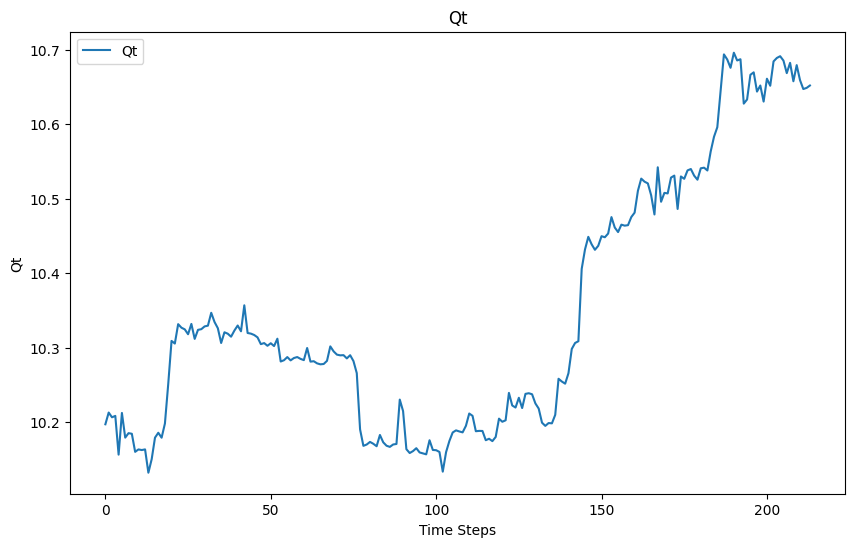

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='Qt')
plt.xlabel('Time Steps')
plt.ylabel('Qt')
plt.title('Qt')
plt.legend()
plt.show()

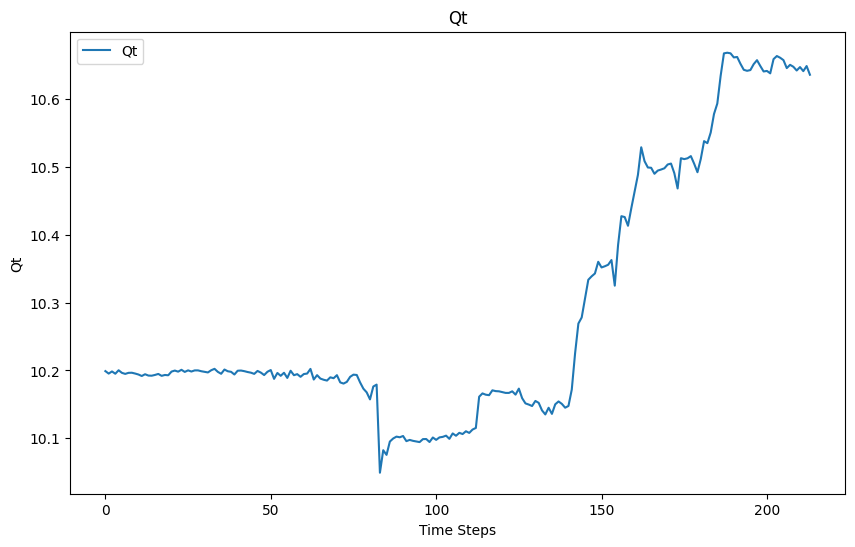

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns, label='Qt')
plt.xlabel('Time Steps')
plt.ylabel('Qt')
plt.title('Qt')
plt.legend()
plt.show()

In [31]:
results = {}
for ticker, data in processed_data.items():
    data = np.flipud(data)
    # 입력 데이터셋 생성
    X, y = create_dataset_with_updated_Q(data, start_index, end_index, time_steps)
    # 모델 정의
    model = Sequential()

    # 첫 번째 LSTM 층 추가. return_sequences=True는 다음 층이 LSTM 층일 때 필요
    model.add(LSTM(1000, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))

    # Dropout을 추가하여 과적합 방지
    # model.add(Dropout(0.2))

    # 두 번째 LSTM 층 추가
    # model.add(LSTM(1000, return_sequences=True))

    # 또 다른 Dropout 층
    # model.add(Dropout(0.2))

    # 세 번째 LSTM 층 추가
    # model.add(LSTM(1000))

    # 마지막 Dense 층 추가. 출력층
    model.add(Dense(1))

    # 모델 컴파일
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 모델 학습
    model.fit(X, y, epochs=200, batch_size=32, verbose=0)

    predicted_returns = lstm_predict(X, model)
    results[ticker] = {
        'predicted_returns': predicted_returns
    }
    

Predicting: 100%|██████████| 214/214 [00:11<00:00, 18.68it/s]


#### Verification을 위해 predicted returns 분리 후 pickle로 같은 디렉토리에 저장

In [32]:
# 각 티커별 predicted returns를 저장할 딕셔너리
predicted_returns_by_ticker = {}

for ticker, result in results.items():
    predicted_returns_by_ticker[ticker] = result['predicted_returns']

# 결과 출력
for ticker, predicted_returns in predicted_returns_by_ticker.items():
    print(f"Ticker: {ticker}")
    print("Predicted Returns:", predicted_returns)
    print()

Ticker: BTC
Predicted Returns: [10.279165, 10.276721, 10.279179, 10.269972, 10.27119, 10.2760935, 10.280171, 10.284179, 10.276403, 10.273064, 10.279025, 10.27575, 10.275634, 10.275715, 10.277796, 10.278667, 10.279485, 10.27358, 10.272206, 10.274278, 10.284509, 10.2881155, 10.285053, 10.286984, 10.279689, 10.278438, 10.280265, 10.282708, 10.280775, 10.279081, 10.286551, 10.276736, 10.2755375, 10.280415, 10.278838, 10.278983, 10.284148, 10.279376, 10.273781, 10.270329, 10.280522, 10.277925, 10.278885, 10.284287, 10.287852, 10.274776, 10.273225, 10.273734, 10.275633, 10.277989, 10.279831, 10.270222, 10.278157, 10.269214, 10.279283, 10.271321, 10.279139, 10.271554, 10.27507, 10.268792, 10.270044, 10.273568, 10.281176, 10.273683, 10.28214, 10.27532, 10.270305, 10.266998, 10.2783785, 10.276686, 10.281346, 10.272561, 10.2762, 10.265622, 10.266061, 10.273622, 10.275624, 10.2723055, 10.282752, 10.291774, 10.271662, 10.268807, 10.273574, 10.179246, 10.170556, 10.197381, 10.224154, 10.234735, 10.

In [34]:
with open('/home/user/exercise_j/GPT Project/Sentiment-Portfolio-Asset-allocation/Crypto_ECM-LSTM/CMC_Twitter_Total/q_vector_epoch_price_log.pkl', 'wb') as f:
    pickle.dump(predicted_returns_by_ticker, f)